# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [25]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from src import plotter as plotter
from src import model as model

%matplotlib widget


plotter.initialize(plt)

# Configure the model parameters

In [26]:
# Global settings
vmax = 4.2
vmin = 3.0

# Configure model parameters

# SEI growth parameters
alpha_SEI = 0.5    # [-]        SEI charge transfer coefficient
c_EC_bulk = 4541   # mol/m3     Concentration of EC in bulk electrolyte 
delta_SEI_0 = 5e-9 # m          Initial SEI thickness
V_sei = 9.585e-5   # m3/mol     SEI molar volume
L_n = 80e-6        # m          Negative electrode thickness
k_SEI = 1e-15      # m/s        SEI kinetic rate constant 
D_SEI = 2e-16      # m2/s       SEI layer diffusivity
R = 20e-6          # m          Anode particle radius
epsilon = 0.7      # [-]        Anode solid material fraction
a_SEI = 3 * epsilon / R #       Anode specific surface area
U_SEI = 0.4        # V          SEI equilibrium reaction potential

F = 96485.33212    # C/mol      Faraday's constant
T = 273.15 + 25    # Kelvin     Temperature
R = 8.314          # J/mol/K    Universal gas constant


# eR-RC parameters at the electrode level
R0p = 0.041
R0n = 0.041
R1p = 0.158
R1n = 0.158
C1p = 38000
C1n = 38000

# eSOH parameters
Cn = 5 # Ah
Cp = 6 # Ah
theta_n_init = 0.0
theta_p_init = 1.0

# Simulation parameters
dt               = 1.0
sim_time_seconds = 30*3600 # Total simulation time
t_vec            = np.arange(0, sim_time_seconds, dt)

chg_current_amps = 0.5
dch_current_amps = -0.5
I_app = np.zeros(t_vec.shape) # Amperes, positive is charge
I_cv = 0.5 / 20 

theta_n_vec = model.initialize_sim_vec(t_vec, theta_n_init)
theta_p_vec = model.initialize_sim_vec(t_vec, theta_p_init)
ocv_n_vec   = model.initialize_sim_vec(t_vec, model.Un(theta_n_init))
ocv_p_vec   = model.initialize_sim_vec(t_vec, model.Up(theta_p_init))
vt_vec      = model.initialize_sim_vec(t_vec, ocv_p_vec[0] - ocv_n_vec[0])
ocv_vec     = model.initialize_sim_vec(t_vec, ocv_p_vec[0] - ocv_n_vec[0])
I_r1p_vec   = model.initialize_sim_vec(t_vec, 0)
I_r1n_vec   = model.initialize_sim_vec(t_vec, 0)
eta_sei_vec = model.initialize_sim_vec(t_vec, 0)
j_sei_vec   = model.initialize_sim_vec(t_vec, 0)
I_sei_vec   = model.initialize_sim_vec(t_vec, 0)
Q_sei_vec   = model.initialize_sim_vec(t_vec, 0)
delta_sei_vec = model.initialize_sim_vec(t_vec, delta_SEI_0)
delta_n_vec = model.initialize_sim_vec(t_vec, model.En(theta_n_init))
delta_p_vec = model.initialize_sim_vec(t_vec, model.Ep(theta_p_init))
expansion_vec = model.initialize_sim_vec(t_vec, 0)


# CV Mode Equations

Current decay during CV mode is analytically solvable for the nRC case:

$$
I_{CV} = \frac{V_t - V_{OC} - \sum_n R_{1,n}I_{R_{1,n}}\exp{(-\frac{\Delta t}{\tau_n})}}{\sum_n(R_{0,n} + R_{1,n}(1-\exp{(-\frac{\Delta t}{\tau_n})}))}
$$

# SEI growth dynamics

SEI growth is modeled using the following approach.

The total applied current is distributed across intercalation and SEI

$$
I_{app} = I_{int} + I_{SEI}
$$

The SEI current is related to the current density by (Eqn. 1j from Sulzer2021):

$$
I_{SEI} = -a_{s,n}L_n j_{SEI}
$$

where 
- $a$ is the specific surface area [m^2] 
- $L_n$ is the negative electrode length [m] 
- $j_{SEI}$ is the SEI volumetric current density [A/m^3].

The mixed reaction and diffusion limited SEI current density is (Eqn. 16 from Sulzer2021):

$$
j_{SEI} = \frac{-c_{EC}^{bulk}}{1/(Fk_{SEI}\exp(-\alpha_{SEI}F\eta_{SEI}/RT)) + a_{sei}\delta_{SEI}/(D_{SEI}F)}
$$

Note that $j_{SEI} = f(\eta_{SEI}, \delta_{SEI})$. All the other terms in the equation are constants.

The SEI reaction overpotential $\eta_{SEI}$ is (Eqn. 1g from Sulzer2021):

$$
\eta_{SEI} = \phi_{s,n} - \phi_e - U_{SEI} - j_{tot,k}R_{film}\delta_{SEI}
$$

But we also know from Equation [1f] that

$$
\eta_{n} = \phi_{s,n} - \phi_e - U_n(c_{s,n}^{surf}) - j_{tot,n}R_{film}\delta_{SEI}
$$

which can be used to eliminate some variables and re-express the SEI overpotential as

$$
\eta_{SEI} = \eta_n + U_n(c_{s,n}^{surf}) - U_{SEI}
$$

Finally, the SEI thickness can be updated using [1h] from Sulzer2021:

$$
\frac{d\delta_{SEI}}{dt} = \bar{V}_{SEI} \frac{a_{s,n} j_{SEI}}{2F}
$$




In [27]:

mode = 'cc_charge'

print('Starting simulation...')
for k in range(0, len(t_vec) - 1):

    # Constant current
    if mode == 'cc_charge':
        
        I_app[k] = chg_current_amps

        dQ = I_app[k] * dt / 3600 # Amp-hours    

        # Stoichiometry update
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        # Equilibrium potential updates
        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])

        # Cathode and anode expansion function update    
        delta_n_vec[k + 1] = model.En(theta_n_vec[k + 1])
        delta_p_vec[k + 1] = model.Ep(theta_p_vec[k + 1])

        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        # Current updates (branch current for RC element)
        I_r1p_vec[k+1] =       np.exp(-dt/(R1p*C1p))  * I_r1p_vec[k] + \
                          (1 - np.exp(-dt/(R1p*C1p))) * I_app[k]

        I_r1n_vec[k+1] =       np.exp(-dt/(R1n*C1n))  * I_r1n_vec[k] + \
                          (1 - np.exp(-dt/(R1n*C1n))) * I_app[k]

        # Terminal voltage update
        # Vt = Up + eta_p - Un + eta_n
        vt_vec[k+1] = ocv_p_vec[k+1] + R1p * I_r1p_vec[k] + R0p * I_app[k] - \
                     (ocv_n_vec[k+1] - R1n * I_r1n_vec[k] - R0n * I_app[k]) 

        # SEI growth update
        eta_int = I_app[k] * R0n
        eta_sei_vec[k+1] = eta_int + ocv_n_vec[k+1] - U_SEI

        # Mixed reaction and diffusion limited SEI current density
        AA = F * k_SEI * np.exp( -alpha_SEI * F * eta_sei_vec[k+1] / (R * T) )

        # Should this be k or k+1?
        BB = a_SEI * delta_sei_vec[k] / (D_SEI * F)

        j_sei_vec[k+1] = - c_EC_bulk / (AA + BB)
        
        ## Current density to current conversion
        I_sei_vec[k+1] = - j_sei_vec[k+1] * a_SEI * L_n

        # Integrate SEI current to get SEI capacity
        Q_sei_vec[k+1] = Q_sei_vec[k] + I_sei_vec[k+1] * dt / 3600

        # Update SEI thickness
        delta_sei_vec[k+1] = delta_sei_vec[k] + \
                             dt * (V_sei * a_SEI * np.abs(j_sei_vec[k+1]) ) / (2 * F) 
        
        # Check for constant voltage condition
        if vt_vec[k+1] >= vmax:
            print('Switching from CC charge to CV charge...')
            mode = 'cv_charge'
            vt_vec[k+1] = vmax
        
    # Constant voltage
    elif mode == 'cv_charge':
        
        # Input current update during potentiostatic mode operation
        I_app[k+1] = ( vt_vec[k] - ocv_vec[k] - \
                        R1p * np.exp(-dt/(R1p*C1p)) * I_r1p_vec[k] - \
                        R1n * np.exp(-dt/(R1n*C1n)) * I_r1n_vec[k] ) / \
                    ( ( 1 - np.exp(-dt/(R1n*C1n)) ) * R1n + R0n + \
                      ( 1 - np.exp(-dt/(R1p*C1p)) ) * R1p + R0p )

        # Branch current update
        I_r1n_vec[k+1] =        np.exp(-dt/(R1n*C1n))  * I_r1n_vec[k] + \
                           (1 - np.exp(-dt/(R1n*C1n))) * I_app[k+1]

        I_r1p_vec[k+1] =        np.exp(-dt/(R1p*C1p))  * I_r1p_vec[k] + \
                           (1 - np.exp(-dt/(R1p*C1p))) * I_app[k+1]

        dQ = I_app[k] * dt / 3600

        # Stoichiometry update
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        # Equilibrium potential updates
        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])
        delta_n_vec[k + 1] = model.En(theta_n_vec[k + 1])
        delta_p_vec[k + 1] = model.Ep(theta_p_vec[k + 1])

        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        # Current updates (branch current for RC element)
        I_r1n_vec[k+1] =       np.exp(-dt/(R1n*C1n))  * I_r1n_vec[k] + \
                          (1 - np.exp(-dt/(R1n*C1n))) * I_app[k] 

        I_r1p_vec[k+1] =       np.exp(-dt/(R1p*C1p))  * I_r1p_vec[k] + \
                          (1 - np.exp(-dt/(R1p*C1p))) * I_app[k] 

        # Terminal voltage update
        vt_vec[k+1] = vmax

        # SEI growth update
        eta_int = I_app[k] * R0n
        eta_sei_vec[k+1] = eta_int + ocv_n_vec[k+1] - U_SEI

        # Mixed reaction and diffusion limited SEI current density
        AA = F * k_SEI * np.exp( -alpha_SEI * F * eta_sei_vec[k+1] / (R * T) )

        # Should this be k or k+1?
        BB = a_SEI * delta_sei_vec[k] / (D_SEI * F)

        j_sei_vec[k+1] = - c_EC_bulk / (AA + BB)
        
        ## Current density to current conversion
        I_sei_vec[k+1] = - j_sei_vec[k+1] * a_SEI * L_n

        # Integrate SEI current to get SEI capacity
        Q_sei_vec[k+1] = Q_sei_vec[k] + I_sei_vec[k+1] * dt / 3600

        # Update SEI thickness
        delta_sei_vec[k+1] = delta_sei_vec[k] + \
                             dt * (V_sei * a_SEI * np.abs(j_sei_vec[k+1]) ) / (2 * F) 
        

        # Check end-of-CV condition
        if np.abs( I_app[k+1] ) < np.abs( I_cv ):
            print('Switching from CV charge to CC discharge...')
            mode = 'cc_discharge'
            continue


    elif mode == 'cc_discharge':

        I_app[k] = dch_current_amps

        dQ = I_app[k] * dt / 3600 # Amp-hours    

        # Stoichiometry update
        theta_n_vec[k + 1] = theta_n_vec[k] + dQ / Cn
        theta_p_vec[k + 1] = theta_p_vec[k] - dQ / Cp 

        # Equilibrium potential updates
        ocv_n_vec[k + 1] = model.Un(theta_n_vec[k + 1])
        ocv_p_vec[k + 1] = model.Up(theta_p_vec[k + 1])
        delta_n_vec[k + 1] = model.En(theta_n_vec[k + 1])
        delta_p_vec[k + 1] = model.Ep(theta_p_vec[k + 1])

        ocv_vec[k + 1]   = ocv_p_vec[k+1] - ocv_n_vec[k+1]

        # Current updates (branch current for RC element)
        I_r1p_vec[k+1] =       np.exp(-dt/(R1p*C1p))  * I_r1p_vec[k] + \
                          (1 - np.exp(-dt/(R1p*C1p))) * -I_app[k]

        I_r1n_vec[k+1] =       np.exp(-dt/(R1n*C1n))  * I_r1n_vec[k] + \
                          (1 - np.exp(-dt/(R1n*C1n))) * -I_app[k]

        assert ~np.isnan(I_r1n_vec[k+1]), 'Something went wrong.'
        assert ~np.isnan(I_r1p_vec[k+1]), 'Something went wrong.'

        # Terminal voltage update
        # Vt = Up + eta_p - Un + eta_n
        vt_vec[k+1] = ocv_p_vec[k+1] + R1p * I_r1p_vec[k] + R0p * -I_app[k] - \
                     (ocv_n_vec[k+1] - R1n * I_r1n_vec[k] - R0n * -I_app[k]) 

        # SEI growth update
        eta_int = I_app[k] * R0n
        eta_sei_vec[k+1] = eta_int + ocv_n_vec[k+1] - U_SEI

        # Mixed reaction and diffusion limited SEI current density
        AA = F * k_SEI * np.exp( -alpha_SEI * F * eta_sei_vec[k+1] / (R * T) )

        # Should this be k or k+1?
        BB = a_SEI * delta_sei_vec[k] / (D_SEI * F)

        j_sei_vec[k+1] = - c_EC_bulk / (AA + BB)
        
        ## Current density to current conversion
        I_sei_vec[k+1] = - j_sei_vec[k+1] * a_SEI * L_n

        # Integrate SEI current to get SEI capacity
        Q_sei_vec[k+1] = Q_sei_vec[k] + I_sei_vec[k+1] * dt / 3600

        # Update SEI thickness
        delta_sei_vec[k+1] = delta_sei_vec[k] + \
                             dt * (V_sei * a_SEI * np.abs(j_sei_vec[k+1]) ) / (2 * F) 
                              
        # Check for constant voltage condition
        if vt_vec[k+1] <= vmin: 
           break

print('Done.')


    # if k % 10 == 0:
        # print(f'k = {k}, t = {t_vec[k]}s, ' +
            #   f'Un = {ocv_n_vec[k]:.4f}, Up = {ocv_p_vec[k]:.4f}, ' + 
            #   f'Vt = {vt_vec[k]:.5f}V ' +
            #   f'x = {theta_n_vec[k]:.3f}, y = {theta_p_vec[k]:.3f}')


Starting simulation...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Done.


# Visualize and save the results

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_47349/1973258414.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('outputs/figures/fig_formation_simulation.png', bbox_inches='tight',


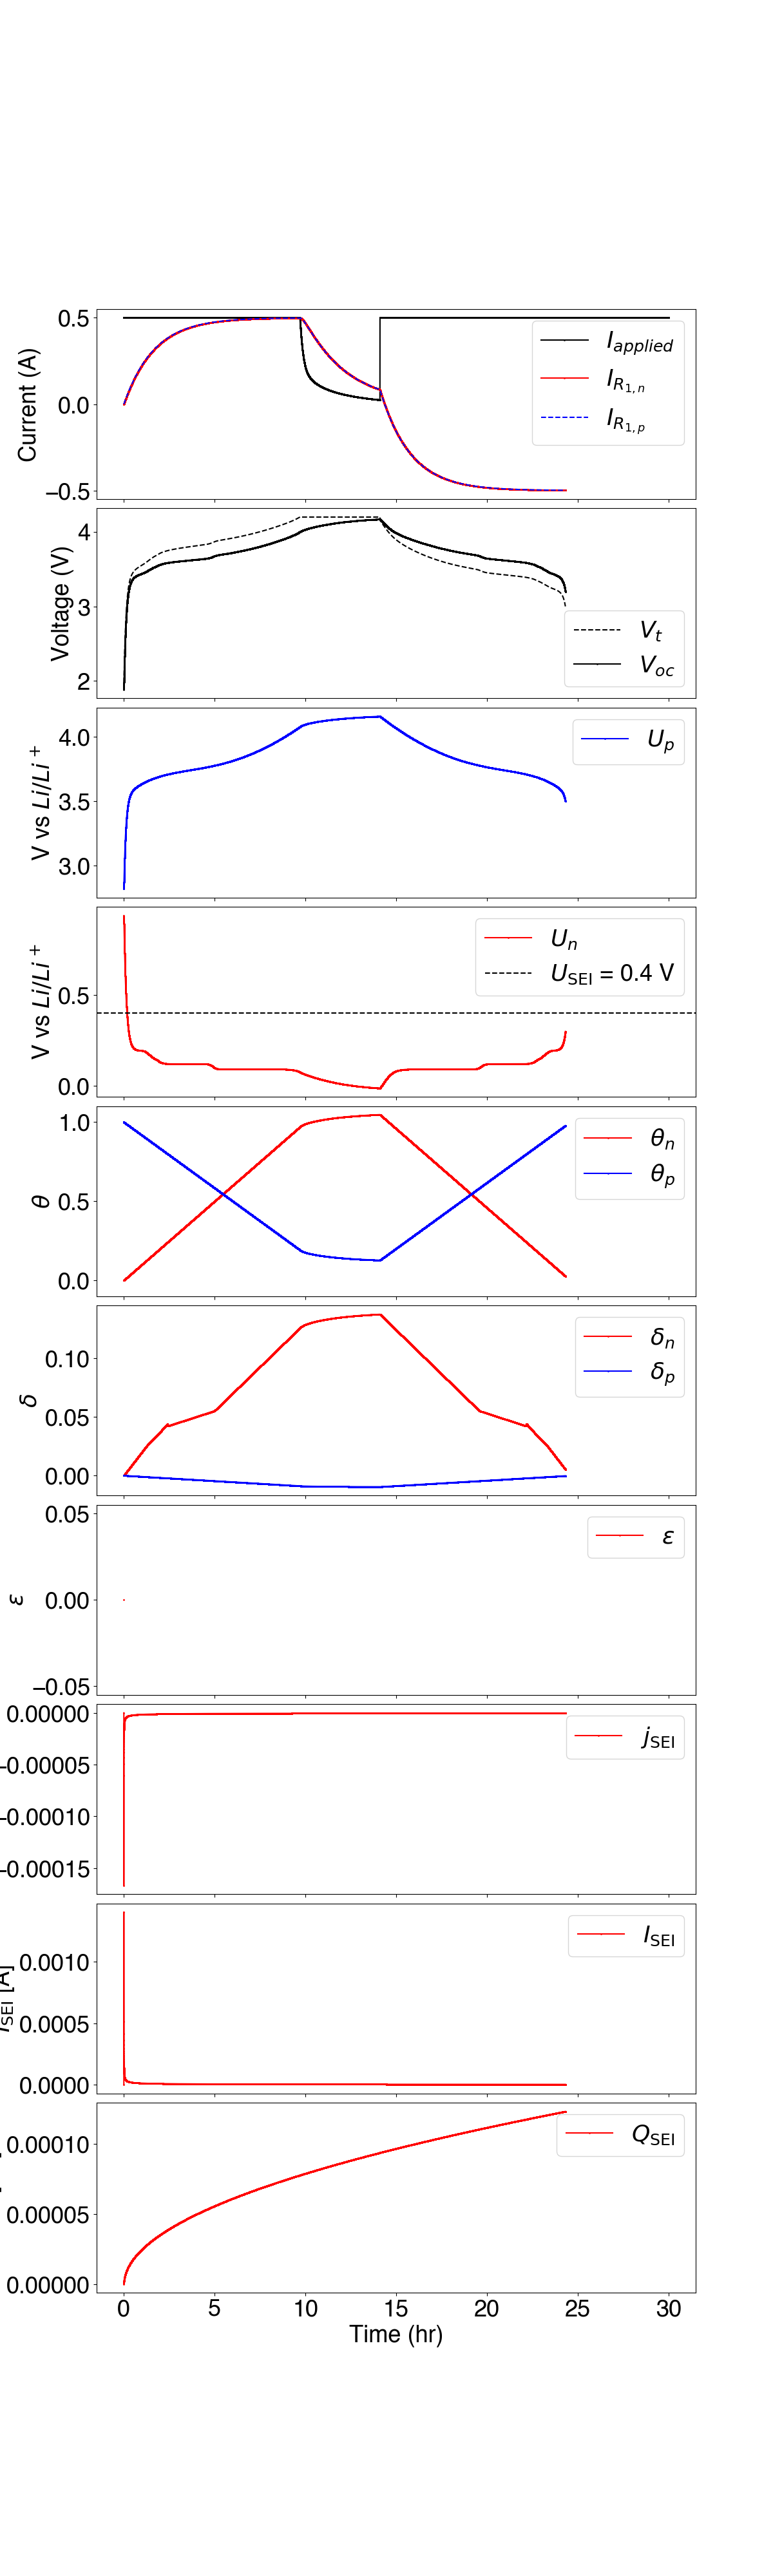

In [31]:

num_subplots = 10

gridspec = dict(hspace=0.05, height_ratios=np.ones(num_subplots))

fig, axs = plt.subplots(nrows=num_subplots, ncols=1, 
                        figsize=(12, num_subplots * 4), 
                        gridspec_kw=gridspec,
                        sharex=True)

[ax.grid(False) for ax in axs]

# Currents
axs[0].plot(t_vec/3600, I_app, color='k', marker='o', ms=1)
axs[0].plot(t_vec/3600, I_r1n_vec, color='r', marker='o', ms=1)
axs[0].plot(t_vec/3600, I_r1p_vec, color='b', ls='--')
axs[0].set_ylabel('Current (A)')
axs[0].legend(['$I_{applied}$', '$I_{R_{1,n}}$', '$I_{R_{1,p}}$'])

# Voltages and Potentials
axs[1].plot(t_vec/3600, vt_vec, ls='--', c='k')
axs[1].plot(t_vec/3600, ocv_vec, marker='o', ms=1, color='k')
axs[1].legend(['$V_t$', '$V_{oc}$'])
axs[1].set_ylabel('Voltage (V)')

axs[2].plot(t_vec/3600, ocv_p_vec, marker='o', ms=1, color='b')
axs[2].legend(['$U_p$'])
axs[2].set_ylabel('V vs $Li/Li^+$')

axs[3].plot(t_vec/3600, ocv_n_vec, marker='o', ms=1, color='r')
axs[3].axhline(y=U_SEI, linestyle='--', color='k')
axs[3].legend(['$U_n$', f'$U_{{\mathrm{{SEI}}}}$ = {U_SEI} V'])
axs[3].set_ylabel('V vs $Li/Li^+$')

# SOC and Lithium Stoichiometries
# axs[2].plot(t_vec/3600, z_vec,
            # marker='o', markersize=1,
            # color='k')

axs[4].plot(t_vec/3600, theta_n_vec, color='r', marker='o', ms=1)
axs[4].plot(t_vec/3600, theta_p_vec, color='b', marker='o', ms=1)
axs[4].legend([r'$\theta_n$', r'$\theta_p$'])
axs[4].set_ylabel(r'$\theta$')
axs[4].set_ylim((-0.1, 1.1))

axs[5].set_ylabel(r'$\delta$')
axs[5].plot(t_vec/3600, delta_n_vec, color='r', marker='o', ms=1)
axs[5].plot(t_vec/3600, delta_p_vec, color='b', marker='o', ms=1)
axs[5].legend([r'$\delta_n$', r'$\delta_p$'])

axs[6].set_ylabel(r'$\varepsilon$')
axs[6].plot(t_vec/3600, expansion_vec, color='r', marker='o', ms=1)
axs[6].legend([r'$\varepsilon$'])

axs[7].plot(t_vec/3600, j_sei_vec, color='r', marker='o', ms=1)
axs[7].legend([r'$j_{\mathrm{SEI}}$'])
axs[7].set_ylabel(r'$j_{\mathrm{SEI}}$ [A/m$^3$]')

axs[8].plot(t_vec/3600, I_sei_vec, color='r', marker='o', ms=1)
axs[8].legend([r'$I_{\mathrm{SEI}}$'])
axs[8].set_ylabel(r'$I_{\mathrm{SEI}}$ [A]')

axs[9].plot(t_vec/3600, Q_sei_vec, color='r', marker='o', ms=1)
axs[9].legend([r'$Q_{\mathrm{SEI}}$'])
axs[9].set_ylabel(r'$Q_{\mathrm{SEI}}$ [Ah]')
axs[9].set_xlabel('Time (hr)')

plt.savefig('outputs/figures/fig_formation_simulation.png', bbox_inches='tight',
            dpi=150)